In [1]:
import os 
import sys
# Add the root folder of your project
root_path = os.path.abspath(os.path.join("..", ".."))  # two levels up from experiments
sys.path.append(root_path)

import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from collections import Counter
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm 
import pickle
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

from weather_classification.weather_dataset import WeatherDataset
from weather_classification.modeling.cnn import CNN_V3_reg_v2
from weather_classification.seed_utils import set_seed
set_seed(1234)

In [2]:
def train_model_improved(model_class, train_dir, val_dir, input_dim, num_classes=11, 
                batch_size=32, epochs=20, lr=1e-3, device="cuda", optimizer="Adam",
                use_scheduler=True, label_smoothing=0.1, p_conv=None, p_fc=None):
    
    model_name = "CNN_definitive"

    PROJECT_ROOT = os.getcwd()

    #metrics_dir = os.path.join(PROJECT_ROOT, "reports", "metrics")
    #models_dir = os.path.join(PROJECT_ROOT, "models")

    models_dir = "../../models/best_model"
    metrics_dir = "../../reports/metrics/best_model"

    os.makedirs(metrics_dir, exist_ok=True)
    os.makedirs(models_dir, exist_ok=True)

    # --- Include grid search params (e.g., dropout rates) in file names ---
    if p_conv is not None and p_fc is not None:
        metrics_path = os.path.join(
            metrics_dir, f"metrics_{model_name}_{optimizer}_{p_conv}_{p_fc}.pkl"
        )
        model_path = os.path.join(
            models_dir, f"best_model_{model_name}_{optimizer}_{p_conv}_{p_fc}.pth"
        )

    mean = [0.5167, 0.5143, 0.5164]
    std = [0.2378, 0.2359, 0.2393]

    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),  
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])


    # Datasets with different transforms for train/val
    train_dataset = WeatherDataset(train_dir, transform=train_transform)
    val_dataset = WeatherDataset(val_dir, transform=val_transform)

    # Dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                             num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                           num_workers=4, pin_memory=True)

    # Calculate weights per class
    labels = [label for _, label in train_dataset.samples]
    class_counts = Counter(labels)
    num_classes = len(class_counts)

    total_samples = sum(class_counts.values())
    class_weights = [total_samples / class_counts[i] for i in range(num_classes)]
    class_weights_tensor = torch.FloatTensor(class_weights).to(device)

    print("Class counts:", class_counts)
    print("Class weights:", {i: f"{w:.3f}" for i, w in enumerate(class_weights)})

    # Model
    model = model_class(input_dim=input_dim, num_classes=num_classes, p_conv=p_conv, p_fc=p_fc).to(device)
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nModel: {model_name}")
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}\n")

    # Loss with label smoothing to prevent overconfidence
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor, label_smoothing=label_smoothing)
    
    # Optimizer: AdamW with weight decay
    if optimizer == "Adam":
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    elif optimizer == "Momentum":
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    else:
        optimizer = optim.RMSprop(model.parameters(), lr=lr, alpha=0.9)

    
    # Learning rate scheduler - CRITICAL for convergence
    if use_scheduler:
        # ReduceLROnPlateau: reduce LR when val loss plateaus
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6
        )
        # Alternative: CosineAnnealingLR for smoother decay
        # scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)

    best_val_acc = 0.0
    best_val_loss = float('inf')
    patience_counter = 0
    early_stop_patience = 7  # Stop if no improvement for 7 epochs
    
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": [], "lr": []}

    # Training loop
    for epoch in range(epochs):
        model.train()
        running_loss, running_corrects = 0.0, 0

        for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]"):
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()

            preds = outputs.argmax(1)
            running_loss += loss.item() * imgs.size(0)
            running_corrects += (preds == labels).sum().item()

        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects / len(train_dataset)

        # Validation
        model.eval()
        val_loss, val_corrects = 0.0, 0
        with torch.no_grad():
            for imgs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]"):
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)

                preds = outputs.argmax(1)
                val_loss += loss.item() * imgs.size(0)
                val_corrects += (preds == labels).sum().item()

        val_loss /= len(val_dataset)
        val_acc = val_corrects / len(val_dataset)
        
        # Update learning rate
        current_lr = optimizer.param_groups[0]['lr']
        if use_scheduler:
            scheduler.step(val_loss)  # For ReduceLROnPlateau
            # scheduler.step()  # For CosineAnnealingLR

        # Save metrics
        history["train_loss"].append(epoch_loss)
        history["train_acc"].append(epoch_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["lr"].append(current_lr)

        print(f"Epoch {epoch+1}/{epochs}: "
              f"Train Loss={epoch_loss:.4f}, Train Acc={epoch_acc:.4f}, "
              f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}, "
              f"LR={current_lr:.6f}")

        # Save best model based on validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), model_path)
            print(f"✓ Best model saved in {model_path} (val_acc={val_acc:.4f})")
        else:
            patience_counter += 1
            
        # Early stopping
        if patience_counter >= early_stop_patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            print(f"No improvement for {early_stop_patience} consecutive epochs")
            break

    # Save metrics to .pkl
    with open(metrics_path, "wb") as f:
        pickle.dump(history, f)

    print(f"\nTraining complete!")
    print(f"Best val_acc: {best_val_acc:.4f}")
    print(f"Best val_loss: {best_val_loss:.4f}")
    print(f"Metrics saved in {metrics_path}")
    print(f"Model saved in {model_path}")
    
    return model, history

In [3]:
input_dim = 224*224*3  # matches the Resize transform
model, history = train_model_improved(CNN_V3_reg_v2, 
                    train_dir="../../data/train", 
                    val_dir="../../data/val", 
                    input_dim=input_dim,
                    num_classes=11,
                    batch_size=64,
                    epochs=2,
                    lr=1e-3,
                    device="cuda" if torch.cuda.is_available() else "cpu",
                    optimizer = "RMSProp",
                    p_conv = 0.15,
                    p_fc = 0.4)

Class counts: Counter({8: 928, 1: 680, 0: 558, 9: 553, 3: 511, 10: 496, 4: 472, 6: 420, 2: 380, 5: 301, 7: 185})
Class weights: {0: '9.828', 1: '8.065', 2: '14.432', 3: '10.732', 4: '11.619', 5: '18.219', 6: '13.057', 7: '29.643', 8: '5.909', 9: '9.917', 10: '11.056'}

Model: CNN_definitive
Total parameters: 6,981,035
Trainable parameters: 6,981,035



Epoch 1/2 [Val]: 100%|██████████| 11/11 [00:09<00:00,  1.11it/s]


Epoch 1/2: Train Loss=2.3284, Train Acc=0.2540, Val Loss=2.0246, Val Acc=0.4340, LR=0.001000
✓ Best model saved in ../../models/best_model\best_model_CNN_definitive_RMSProp_0.15_0.4.pth (val_acc=0.4340)


Epoch 2/2 [Val]: 100%|██████████| 11/11 [00:07<00:00,  1.38it/s]

Epoch 2/2: Train Loss=1.8884, Train Acc=0.4650, Val Loss=1.8810, Val Acc=0.5191, LR=0.001000
✓ Best model saved in ../../models/best_model\best_model_CNN_definitive_RMSProp_0.15_0.4.pth (val_acc=0.5191)

Training complete!
Best val_acc: 0.5191
Best val_loss: 1.8810
Metrics saved in ../../reports/metrics/best_model\metrics_CNN_definitive_RMSProp_0.15_0.4.pkl
Model saved in ../../models/best_model\best_model_CNN_definitive_RMSProp_0.15_0.4.pth


In [4]:
import torch
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Paths (match the ones you used in train_model_improved)
model_path = "../../models/best_model/best_model_CNN_definitive_RMSprop_0.15_0.4.pth"
metrics_path = "../../reports/metrics/best_model/metrics_CNN_definitive_RMSprop_0.15_0.4.pkl"

# Load training history
with open(metrics_path, "rb") as f:
    history = pickle.load(f)

# Load model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CNN_V3_reg_v2(input_dim=224*224*3, num_classes=11, p_conv=0.15, p_fc=0.4)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()


CNN_V3_reg_v2(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Dropout(p=0.15, inplace=False)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Dropout(p=0.15, inplace=False)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (9): ReLU()
    (10): Dropout(p=0.15, inplace=False)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
    (13): ReLU()
    (14): Dropout(p=0.15, inplace=False)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=12800, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3

In [7]:
def plot_accuracy_loss(history, title_prefix="Training"):
    epochs = range(1, len(history["train_acc"]) + 1)

    # ----- Accuracy plot -----
    plt.figure(figsize=(8,5))
    plt.plot(epochs, history["train_acc"], label="Train Accuracy", color="tab:blue")
    plt.plot(epochs, history["val_acc"], label="Validation Accuracy", color="tab:orange")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{title_prefix} Accuracy")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # ----- Loss plot -----
    plt.figure(figsize=(8,5))
    plt.plot(epochs, history["train_loss"], label="Train Loss", color="tab:green")
    plt.plot(epochs, history["val_loss"], label="Validation Loss", color="tab:red")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{title_prefix} Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


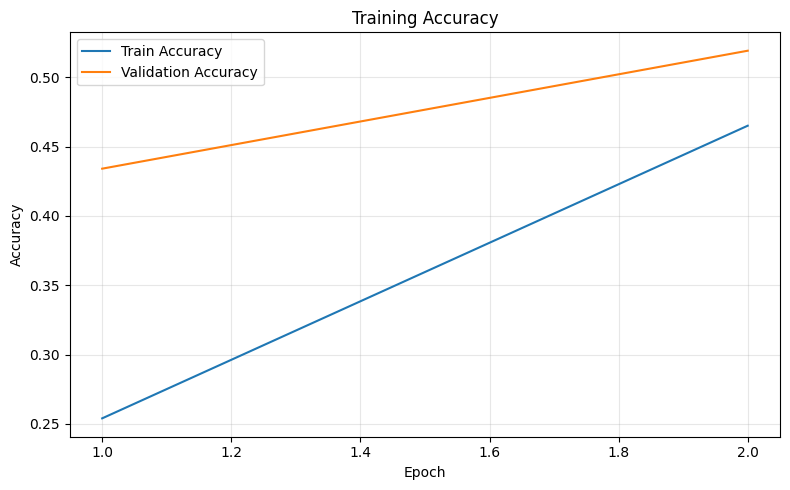

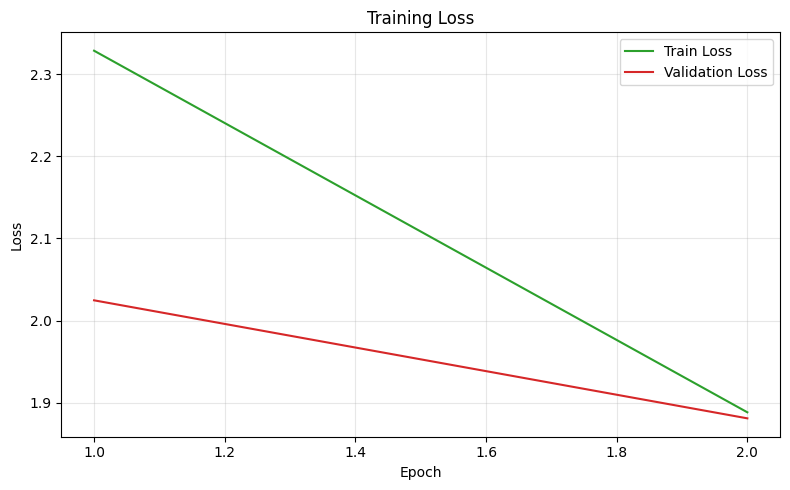

In [10]:
plot_accuracy_loss(history)

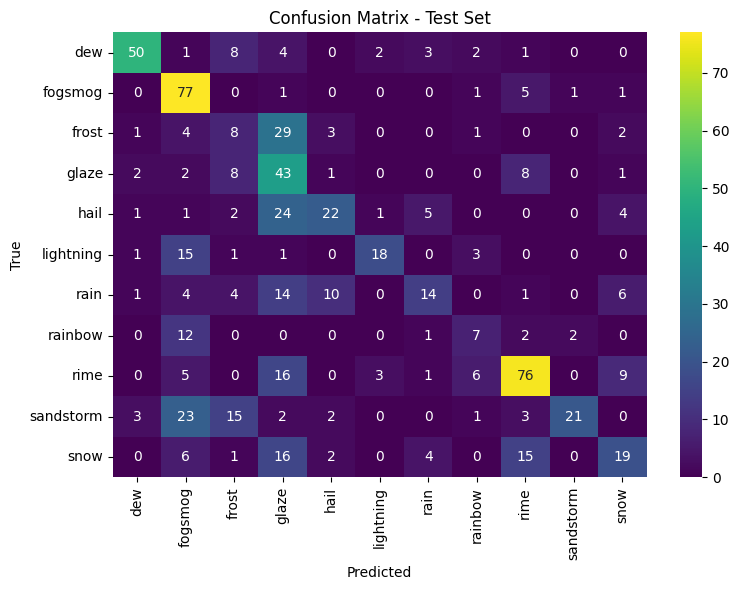

In [13]:
mean = [0.5167, 0.5143, 0.5164]
std = [0.2378, 0.2359, 0.2393]

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])
# Prepare test dataset and loader
test_dataset = WeatherDataset("../../data/test", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
class_names = test_dataset.classes  # or a list of class names

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Test Set")
plt.tight_layout()
plt.show()
